## Random Forest model for PCOS Dataset (final data)

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from imblearn.over_sampling import SMOTENC
from sklearn.feature_selection import RFE, RFECV
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, auc, roc_curve, recall_score, f1_score, precision_score

### Import Dataset

In [8]:
file_path = "./final_data.csv"
data = pd.read_csv(file_path)
data.head()
data.shape
data.columns
data.describe()

,PCOS (Y/N),Age (yrs),BMI,Pulse rate(bpm),Menstrual Cycle Length(days),Marriage Status (Yrs),Pregnant(Y/N),No. of abortions,I beta-HCG(mIU/mL),II beta-HCG(mIU/mL),...,RBS(mg/dl)_low,RBS(mg/dl)_normal,BP _Systolic (mmHg)_high,BP _Systolic (mmHg)_normal,BP _Diastolic (mmHg)_high,BP _Diastolic (mmHg)_normal,I beta-HCG cat_abnormal,I beta-HCG cat_normal,II beta-HCG cat_abnormal,II beta-HCG cat_normal
count,529.000000,529.000000,529.00000,529.000000,529.000000,529.000000,529.000000,529.000000,529.000000,529.000000,...,529.000000,529.000000,529.000000,529.000000,529.000000,529.000000,529.000000,529.000000,529.000000,529.000000
mean,0.323251,31.425331,24.32344,73.474480,4.937618,7.651607,0.387524,0.283554,677.077289,242.586936,...,0.001890,0.981096,0.003781,0.996219,0.001890,0.998110,0.236295,0.763705,0.158790,0.841210
std,0.468161,5.430222,4.08396,2.709378,1.498068,4.801196,0.487646,0.684607,3385.601032,1621.544221,...,0.043478,0.136314,0.061429,0.061429,0.043478,0.043478,0.425207,0.425207,0.365826,0.365826
min,0.000000,20.000000,12.40000,70.000000,0.000000,0.000000,0.000000,0.000000,1.300000,0.990000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,27.000000,21.60000,72.000000,5.000000,4.000000,0.000000,0.000000,1.990000,1.990000,...,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
50%,0.000000,31.000000,24.20000,72.000000,5.000000,7.000000,0.000000,0.000000,20.000000,1.990000,...,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
75%,1.000000,35.000000,26.70000,74.000000,5.000000,10.000000,1.000000,0.000000,300.530000,100.090000,...,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
max,1.000000,48.000000,38.90000,82.000000,12.000000,30.000000,1.000000,5.000000,32460.970000,25000.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


#### Train Test Split and Feature Scaling

In [9]:
X = data.drop(['PCOS (Y/N)'], axis=1)
y = data['PCOS (Y/N)']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.shape)
print(X_test.shape)

category_col_names = ['Blood Group_A+', 'Blood Group_A-', 'Blood Group_AB+','Blood Group_AB-', 
'Blood Group_B+', 'Blood Group_B-', 'Blood Group_O+', 'Blood Group_O-', 
'Menstrual Cycle(R/I)_irregular', 'Menstrual Cycle(R/I)_regular', 'Weight gain(Y/N)', 
'hair growth(Y/N)', 'Skin darkening (Y/N)', 'Hair loss(Y/N)', 'Pimples(Y/N)',
'Fast food (Y/N)', 'Reg.Exercise(Y/N)', 'Pregnant(Y/N)']
numeric_col_names = X.loc[:, ~X.columns.isin(category_col_names)].columns

scaler = StandardScaler()
X_train[numeric_col_names] = scaler.fit_transform(X_train[numeric_col_names])
X_test[numeric_col_names] = scaler.transform(X_test[numeric_col_names])

(423, 65)
(106, 65)


### Resampling with SMOTENC

In [10]:
smotenc = SMOTENC(categorical_features=category_col_names, random_state=42)
X_train_resampled, y_train_resampled = smotenc.fit_resample(X_train, y_train)

### Building Random Forest Classifier

In [11]:
rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train_resampled, y_train_resampled)
y_pred=rf.predict(X_test)
print("Test Accuracy:", accuracy_score(y_pred, y_test))

Test Accuracy: 0.9245283018867925


### Random Forest Classifier with RFE

In [12]:
rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rfecv = RFECV(estimator=rf, min_features_to_select=1, scoring='roc_auc', cv=5, n_jobs=-1)
X_train_selected = rfecv.fit_transform(X_train_resampled, y_train_resampled)
X_test_selected = rfecv.transform(X_test)
selected_features = X.columns[rfecv.support_]

print("selected features:", selected_features)

rf.fit(X_train_selected, y_train_resampled)
y_pred=rf.predict(X_test_selected)

print("Test Accuracy:", accuracy_score(y_pred, y_test))

selected features: Index(['Age (yrs)', 'BMI', 'Pulse rate(bpm)', 'Menstrual Cycle Length(days)',
       'Marriage Status (Yrs)', 'Pregnant(Y/N)', 'No. of abortions',
       'I   beta-HCG(mIU/mL)', 'II    beta-HCG(mIU/mL)', 'FSH/LH',
       'Waist:Hip Ratio', 'Weight gain(Y/N)', 'hair growth(Y/N)',
       'Skin darkening (Y/N)', 'Hair loss(Y/N)', 'Pimples(Y/N)',
       'Fast food (Y/N)', 'Reg.Exercise(Y/N)', 'Follicle No. (L)',
       'Follicle No. (R)', 'Avg. F size (L) (mm)', 'Avg. F size (R) (mm)',
       'Endometrium (mm)', 'Blood Group_A+', 'Blood Group_A-',
       'Blood Group_AB+', 'Blood Group_B+', 'Blood Group_B-', 'Blood Group_O+',
       'Menstrual Cycle(R/I)_irregular', 'Menstrual Cycle(R/I)_regular',
       'Symptoms score', 'Unhealthy living score', 'RR (breaths/min)_high',
       'RR (breaths/min)_normal', 'Hb(g/dl)_low', 'Hb(g/dl)_normal',
       'TSH (mIU/L)_high', 'TSH (mIU/L)_normal', 'AMH(ng/mL)_high',
       'AMH(ng/mL)_low', 'AMH(ng/mL)_normal', 'PRL(ng/mL)_high',


### Hyperparameter Tuning

In [13]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='roc_auc', n_jobs=-1, verbose=1)
grid_search.fit(X_train_selected, y_train_resampled)

print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation ROC AUC:", grid_search.best_score_)

rf_best = grid_search.best_estimator_

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best Parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best Cross-Validation ROC AUC: 0.9782988172184848


### Model Evaluation

AUC score:  0.9771959459459458
New Model Test Accuracy: 0.9245283018867925


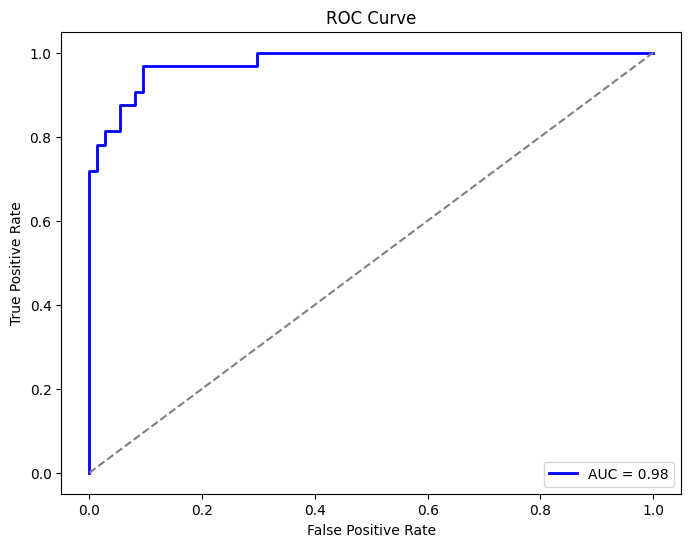

In [14]:
y_pred_best = rf_best.predict(X_test_selected)
y_probs = rf_best.predict_proba(X_test_selected)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

print("AUC score: ", roc_auc)
print("New Model Test Accuracy:", accuracy_score(y_test, y_pred_best))

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f"AUC = {roc_auc:.2f}")
plt.plot([0,1], [0,1], color='gray', linestyle="--")
plt.title("ROC Curve")
plt.legend(loc='lower right')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

### Finding Best Threshold & Model Evaluation

Best threshold: 0.43
Accuracy:  0.9245283018867925
Precision:  0.8157894736842105
Recall/Sensitivity:  0.96875
F1 Score:  0.8857142857142857
Specificity:  0.9054054054054054


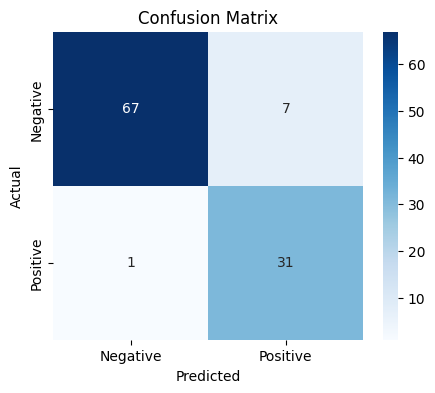

In [15]:
distances = np.sqrt((1 - tpr) ** 2 + fpr ** 2)
best_thresh = thresholds[np.argmin(distances)]
print(f"Best threshold: {best_thresh}")

y_pred_best = [1 if prob >= best_thresh else 0 for prob in y_probs]
print("Accuracy: ", accuracy_score(y_test, y_pred_best))
print("Precision: ", precision_score(y_test, y_pred_best))
print("Recall/Sensitivity: ", recall_score(y_test, y_pred_best))
print("F1 Score: ", f1_score(y_test, y_pred_best))
print("Specificity: ", recall_score(y_test, y_pred_best, pos_label=0))

cm = confusion_matrix(y_test, y_pred_best)
labels = ["True Negatives", "False Positives", "False Negatives", "True Positives"]
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()